In [1]:
import torch
import torch.utils.data as Data
import standard_grid
from main_grid_unaligned_mtgat_prune import get_arguments_argparse, assign_args_to_gc, prepare_data_one_batch

from model import NetMTGATAverageUnalignedConcatMHA
from data.MOSI_dataset_unaligned import MosiDatasetUnaligned
from consts import GlobalConsts as gc

# Load args and configs

In [2]:
import sys
sys.argv = ['']
args = get_arguments_argparse()
args.optimizer, args.task = args.optimizer.lower(), args.task.lower()
gc.dataset = args.task
assign_args_to_gc(args)

# Declare dataloader

In [3]:
dataroot = '/results/username/MTGAT-username/data/cmu_mosi'
gc.data_path = dataroot

gc.config['time_aware_edges'] = 1
gc.config['type_aware_edges'] = 1
gc.config['prune_keep_p'] = 0.8
gc.config['use_all_to_all'] = 0
gc.config['num_gat_layers'] = 6
gc.config['gat_conv_num_heads'] = 4
gc.config['graph_conv_in_dim'] = 64
gc.config['graph_conv_out_dim'] = 64
gc.config['use_pe'] = 1
gc.config['use_prune'] = 1
gc.config['use_ffn'] = 0
gc.config['remove_isolated'] = 1
gc.config['prune_keep_p'] = 0.8
gc.config['use_conv1d'] = 0
gc.config['use_loss_norm'] = 0
gc.config['use_all_to_all'] = 0
gc.dataset = 'mosi_unaligned'
valid_dataset = MosiDatasetUnaligned(dataroot, cls="valid", for_vis=True)
def vis_collate_fn(batch):
    import ipdb
    ipdb.set_trace()
    id_str = batch[0][-1]
    
valid_loader = Data.DataLoader(
    dataset=valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
#     collate_fn=vis_collate_fn
)

# Declare network and load weights

In [4]:
gc.config['return_layer_outputs'] = 1
net = NetMTGATAverageUnalignedConcatMHA(num_gat_layers=6, use_prune=1, use_pe=1)
state_dict = torch.load("/results/username/MTGAT-username-debg/data/gnn_unaligned_20200904_tmgat_ablation_positional_embedding_grid_search_results/3cdd912014ee6fcdbb189176bf216a25ed42606031323494b10207d8054472894fe54d9bf19b43fa95cb1df524bcc57055761b6312a7d8362180ab1509bad6e8/instances/1a42955e7fc7508fa6fc27d0f694ce635429ddd16fdf59636ae50da6761ef3f0ffe00f10ddb49613733b409fb82d4dae295818d9419f84147ea81ebac0ebadf8/snapshots/09-06-2020_T12-49-36/checkpoints/best_model.pt")
net.load_state_dict(state_dict['model_state_dict'])
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Prepare data

In [5]:
train_set = iter(valid_loader)

In [6]:
words, covarep, facet, inputLen, labels, ids = train_set.next()
words, covarep, facet, inputLen, labels, ids = train_set.next()
words, covarep, facet, inputLen, labels, ids = train_set.next()
words, covarep, facet, inputLen, labels, ids = train_set.next()
# words, covarep, facet, inputLen, labels, ids = valid_dataset[3]
# print(ids)
actual_batch_size, input_kwargs, labels = prepare_data_one_batch(covarep, False, False, False, facet, inputLen, labels, words, device)

In [7]:
print(words.shape, covarep.shape, facet.shape, labels.shape)
print(ids, labels)

torch.Size([1, 50, 300]) torch.Size([1, 375, 5]) torch.Size([1, 500, 20]) torch.Size([1])
[('WKA5OygbEKI_1',)] tensor([1.8000], device='cuda:0')


# Network forward

In [8]:
state, batch, nodes_rec, edge_indices_rec, edge_weights_rec, edge_types_rec = net.inference_return_layer_outputs(**input_kwargs)

In [9]:
[l.shape for l in edge_indices_rec], batch.edge_index.shape

([torch.Size([2, 5991]),
  torch.Size([2, 4792]),
  torch.Size([2, 3833]),
  torch.Size([2, 3066]),
  torch.Size([2, 2452]),
  torch.Size([2, 1961]),
  torch.Size([2, 1568])],
 torch.Size([2, 1568]))

In [10]:
batch.x_type, batch.x

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        device='cuda:0'),
 tensor([[-0.6594,  0.9965, -0.8226,  ...,  1.2263, -0.1403,  0.7021],
         [ 0.2754,  1.1310, -0.9848,  ...,  1.2128, -0.1799,  0.6737],
         [ 0.9334,  0.4200, -0.6153,  ...,  1.2325, -0.2084,  0.6445],
         ...,
         [ 1.2421, -0.0919,  0.4142,  ...,  0.5363, -0.2150,  1.1791],
         [ 1.0604, -0.7925, -0.1160,  ...,  0.5465, -0.0788,  1.0557],
         [ 0.1242, -1.1150, -0.8085,  ...,  0.5353, -0.0337,  1.0780]],
        device='cuda:0', grad_fn=<CatBackward>))

In [11]:
[ei.shape for ei in edge_weights_rec[1:]]

[torch.Size([4792, 4]),
 torch.Size([3833, 4]),
 torch.Size([3066, 4]),
 torch.Size([2452, 4]),
 torch.Size([1961, 4]),
 torch.Size([1568, 4])]

# Visualize as Bipartite Graph
## construct vision and text nodes

In [12]:
import numpy as np
visual_nodes = torch.arange((batch.x_type == 0).sum()).numpy()
text_nodes = len(visual_nodes) + torch.arange((batch.x_type == 1).sum())
text_nodes = text_nodes.numpy()
all_nodes = np.concatenate((visual_nodes, text_nodes))

## select the edges and edge weights between vision and text

In [54]:
layer = 3
edge_index = edge_indices_rec[layer].clone()
print(edge_index.shape)
# visual_text_inds = (edge_index[0, :] <= max(all_nodes)) & (edge_index[1, :] <= max(all_nodes))

# Test to Visual
# src_in_visual = (min(visual_nodes) <= edge_index[1, :]) & (edge_index[1, :] <= max(visual_nodes))
# tgt_in_text =  (min(text_nodes) <= edge_index[0, :]) & (edge_index[0, :] <= max(text_nodes))

# Visual to Text
src_in_visual = (min(visual_nodes) <= edge_index[0, :]) & (edge_index[0, :] <= max(visual_nodes))
tgt_in_text =  (min(text_nodes) <= edge_index[1, :]) & (edge_index[1, :] <= max(text_nodes))

visual_text_inds =  src_in_visual & tgt_in_text
visual_text_edges = edge_index[:, visual_text_inds].cpu().detach().numpy()

edge_weights = edge_weights_rec[layer].mean(-1).clone()
visual_text_weights = edge_weights[visual_text_inds].cpu().detach().numpy()

edge_types = edge_types_rec[layer].clone()
edge_types = torch.zeros_like(edge_types_rec[layer])
visual_text_edge_types = edge_types[visual_text_inds].cpu().detach().numpy()

all_nodes, edge_index[:, visual_text_inds]
visual_text_edges.shape, visual_text_weights.shape, np.unique(visual_text_edge_types)

torch.Size([2, 3066])


((2, 412), (412,), array([0]))

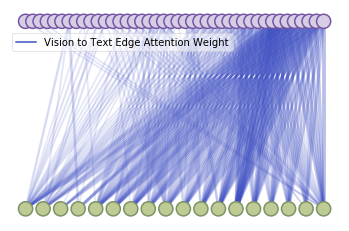

In [55]:
from visualizations import visualize_graph_dynamic
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots()
visualize_graph_dynamic(visual_nodes, text_nodes, visual_text_edges, visual_text_weights, visual_text_edge_types, aspect_ratio=5/3, linewidths=1.5, threshold=0.016,
                       node_size=200)
cmap_list = ['RdYlBu', 'coolwarm', 'summer']
# cmap = 
# print(cmap(2))
# p1, = ax.plot([0], label="Current Edge", color=cm.get_cmap('RdYlBu')(2))
p2, = ax.plot([0], label="Vision to Text Edge Attention Weight", color=cm.get_cmap('coolwarm')(2))
# p3, = ax.plot([0], label="Future Edge", color=cm.get_cmap('summer')(2))
handles, labels = ax.get_legend_handles_labels()
# ax.set_title("Past, current, future edges pointing from text to vision")
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(0, 0.9), framealpha=0.5, fancybox=True)
ax.axis("off")
for item in [fig, ax]:
    item.patch.set_visible(False)
plt.savefig("bimodal.jpg", dpi=300, transparante=True, bbox_inches='tight')
# plt.xlabel('longitude')
# plt.legend((0,), ("label1",))

# Visualize as Circular Graph

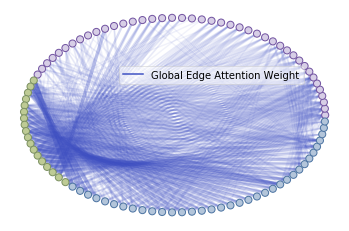

In [59]:
from visualizations import visualize_graph_circular
import numpy as np
import matplotlib.pyplot as plt
visual_nodes = torch.arange((batch.x_type == 0).sum()).numpy()
text_nodes = len(visual_nodes) + torch.arange((batch.x_type == 1).sum())
text_nodes = text_nodes.numpy()
audio_nodes = len(visual_nodes) + len(text_nodes) + torch.arange((batch.x_type==2).sum())
all_nodes = np.concatenate((visual_nodes, text_nodes))

edge_index = edge_indices_rec[layer].clone().cpu().detach().numpy()
edge_weights = edge_weights_rec[layer].mean(-1).clone().cpu().detach().numpy()
edge_types = edge_types_rec[layer].clone().cpu().detach().numpy()
edge_types = np.zeros_like(edge_types)

fig, ax = plt.subplots()
visualize_graph_circular(visual_nodes, text_nodes, audio_nodes, edge_index, edge_weights, edge_types, threshold=0.031, node_size=50)

cmap_list = ['coolwarm', 'summer', 'RdYlBu']
# cmap = 
# print(cmap(2))
# p1, = ax.plot([0], label="Current Edge", color=cm.get_cmap('RdYlBu')(2))
p2, = ax.plot([0], label="Global Edge Attention Weight", color=cm.get_cmap('coolwarm')(2))
# p3, = ax.plot([0], label="Future Edge", color=cm.get_cmap('summer')(2))
handles, labels = ax.get_legend_handles_labels()
# ax.set_title("Past, current, future edges pointing from text to vision")
ax.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(0.9, 0.75), framealpha=0.5, fancybox=True)
ax.axis("off")
for item in [fig, ax]:
    item.patch.set_visible(False)
plt.savefig("trimodal_circular.jpg", dpi=300, transparante=True, bbox_inches='tight')

## Read the actual data corresponding to the node type and index

In [ ]:
from graph_model.get_image_and_text import get_text_and_image
import matplotlib.pyplot as plt
import pickle as pk
path_to_raw_videos = "/results/username/MOSI_vis_data/Raw/Video/Segmented"
path_to_unaligned_pickle = "/results/username/MOSI_vis_data/mosi_data_noalign.pkl"
path_to_processed_text_pickle = "/results/username/MOSI_vis_data/processed_text.pkl"
save_image_path = "/home/yourusername/image_path"
with open(path_to_unaligned_pickle, 'rb') as f: data = pk.load(f)
video_name = data['train']['id'][0][0].decode("utf-8")
print(video_name)
print(ids)
video_name = ids[0][0]
print(video_name)
ret = get_text_and_image(path_to_raw_videos, path_to_unaligned_pickle, path_to_processed_text_pickle,
                         save_image_path, video_name, modality="video", node_index=13)
# print(ret)
plt.imshow(ret)
print(labels)